# Biblioteki

In [1]:
import numpy as np
import pandas as pd
import json
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['figure.figsize'] = [15, 10]
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, Lasso

import itertools

# Deklaracje

In [2]:
def plot_ts(ts):
    fig, ax = plt.subplots()
    ts_roll_mean = ts.rolling(window=12).mean()
    ts_roll_std = ts.rolling(window=12).std()
    
    ts.plot(color='blue', label='Original', use_index=False)
    ts_roll_mean.plot(color='red', label="Rolling mean", use_index=False)
    ts_roll_std.plot(color='black', label="Rolling std", use_index=False)
    
    ax.set_xticklabels(ts.index)
    fig.autofmt_xdate()
    
    
    plt.xlabel('Date')
    plt.ylabel('Return ratio')
    plt.show()
    
def perform_dft(ts):
    #Perform Augmented Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(y_train, autolag='AIC')
    add_col = []
    values = list(dftest[0:4])
    for key,value in dftest[4].items():
        add_col.append('Critical Value (%s)'%key)
        values.append(value)

    dfoutput = pd.DataFrame(data = [values], index=['Wartość'], columns=['Test Statistic','p-value','#Lags Used','Number of Observations Used']+add_col)
    display(dfoutput)

def decompose(ts):
    decomposition = seasonal_decompose(ts, freq=10) 
    decomposition.plot()
    plt.show()
    
def find_best_hparameters(ts, x, pmax, d, qmax):
    errors_dict = {}
    rmse_value_list = []
    order_list = []
    for p in range(pmax+1):
        for q in range(qmax+1):
            order = (p,d,q)
            try:
                model = SARIMAX(ts, x, order=order, freq='B', trend='c')
                results = model.fit()
                rmse_value = rmse(results.fittedvalues, ts)
                rmse_value_list.append(rmse_value)
                order_list.append(order)
            except Exception as e:
                errors_dict[str(order)] = {'error_str': str(e)}
    
    errors = pd.DataFrame.from_dict(errors_dict, orient='index')
    display(errors)
    
    results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
    best10 = tuple(order for order, rmse_value in results[:10])
    return best10, results

# def find_best_extra_vars(ts, x_array, order, n_max=4):
#     errors_dict = {}
#     rmse_value_list = []
#     order_list = []
#     for i in range(2, n_max+1):
#         print(i)
#         try:
#             model = SARIMAX(ts, order=order, freq='B')
#             results = model.fit()
#             rmse_value = rmse(results.fittedvalues, ts)
#             rmse_value_list.append(rmse_value)
#             order_list.append(order)
#         except Exception as e:
#             errors_dict[str(order)] = {'error_str': str(e)}
    
#     errors = pd.DataFrame.from_dict(errors_dict, orient='index')
#     display(errors)
    
#     results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
#     best10 = tuple(order for order, rmse_value in results[:10])
#     return best10, results

def select_best_orders_from_best10(ts, x, best10):
    errors_dict = {}
    rmse_value_list = []
    order_list = []
    for order in best10:
        try:
            model = SARIMAX(ts, x, order=order, freq='B', trend='c')
            results = model.fit()
            rmse_value = rmse(results.fittedvalues, ts)
            rmse_value_list.append(rmse_value)
            order_list.append(order)
        except Exception as e:
            errors_dict[str(order)] = {'error_str': str(e)}
            
    errors = pd.DataFrame.from_dict(errors_dict, orient='index')
    display(errors)
    
    results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
    best = results[0][0]
    return best, results

def test_orders(ts, orders):
    errors_dict = {}
    rmse_value_list = []
    order_list = []
    for order in orders:
        try:
            model = ARIMA(ts, order=order, freq='B')
            results = model.fit()
            rmse_value = rmse(results.fittedvalues, ts)
            rmse_value_list.append(rmse_value)
            order_list.append(order)
        except Exception as e:
            errors_dict[str(order)] = {'error_str': str(e)}
            
    errors = pd.DataFrame.from_dict(errors_dict, orient='index')
    display(errors)
    
    results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
    best = results[0][0]
    return best, results

def show_est_plot(ts, x_array=None, order=None, zero=False, naiwny=False, label="Wykres"):
    if zero == True:
        z = [0]*len(ts)
        rmse_value = rmse(ts, z)
        plt.plot(ts.index, z, label="Zero", color='red')
        plt.plot(ts.index, ts, label=label, color='blue')
        plt.title(f'{label} (RMSE: {rmse_value})')
        plt.show()
    elif naiwny == True:
        rmse_value = rmse(ts[1:], ts.shift()[1:])
        plt.plot(ts[1:].index, ts.shift()[1:], label="Naiwny", color='red')
        plt.plot(ts[1:].index, ts[1:], label=label, color='blue')
        plt.title(f'{label} (RMSE: {rmse_value})')
        plt.show()
    else:
        model = SARIMAX(ts, x_array, order=order, freq='B', trend='c')
        results = model.fit()
        rmse_value = rmse(results.fittedvalues, ts)
        plt.plot(ts.index, results.fittedvalues, label=label, color='red')
        plt.plot(ts.index, ts, label=label, color='blue')
        plt.title(f'{label} (RMSE: {rmse_value})')
        plt.show()
        

# Wczytanie zbiorów

In [3]:
train = pd.read_csv('datasets/podzielone/ekonometryczne/stacjonarne/train_ekon.csv', index_col=0)
val1 = pd.read_csv('datasets/podzielone/ekonometryczne/stacjonarne/valid1_ekon.csv', index_col=0)
val2 = pd.read_csv('datasets/podzielone/ekonometryczne/stacjonarne/valid2_ekon.csv', index_col=0)
val3 = pd.read_csv('datasets/podzielone/ekonometryczne/stacjonarne/valid3_ekon.csv', index_col=0)
test = pd.read_csv('datasets/podzielone/ekonometryczne/stacjonarne/test_ekon.csv', index_col=0)

train.index = pd.to_datetime(train.index)
val1.index = pd.to_datetime(val1.index)
val2.index = pd.to_datetime(val2.index)
val3.index = pd.to_datetime(val3.index)
test.index = pd.to_datetime(test.index)

whole = pd.concat([train, val1, val2, val3, test]).fillna(method='bfill')

train1 = train.asfreq('B', method='bfill').fillna(method='bfill')
train2 = pd.concat([train, val1]).asfreq('B', method='bfill').fillna(method='bfill')
train3 = pd.concat([train, val1, val2]).asfreq('B', method='bfill').fillna(method='bfill')

val1 = val1.asfreq('B', method='bfill').fillna(method='bfill')
val2 = val2.asfreq('B', method='bfill').fillna(method='bfill')
val3 = val3.asfreq('B', method='bfill').fillna(method='bfill')
test = test.asfreq('B', method='bfill').fillna(method='bfill')

val = pd.concat([val1, val2, val3]).asfreq('B', method='bfill').fillna(method='bfill')


In [4]:
train1["day_of_week"] = train1.index.dayofweek
train1["day_of_year"] = train1.index.dayofweek
train1["week"] = train1.index.week
train1["quarter"] = train1.index.quarter


val["day_of_week"] = val.index.dayofweek
val["day_of_year"] = val.index.dayofweek
val["week"] = val.index.week
val["quarter"] = val.index.quarter


# Wybór hiperparametrów

In [5]:
last_candidates = [
    ['MIN_diff_1', 'MININDEX_diff_1_shift_19'],
    ['SandP_diff_1', 'NasdaqTech_diff_1'],
    ['SandP_diff_1', 'NasdaqTech_diff_1', 'MININDEX_diff_1_shift_19', 'week'],
]

## Trening 1

In [6]:
results_of_e = []
for train_variables in last_candidates:
    X_train1 = train1[train_variables]
    y_train1 = train1['y_return_ratio']
    
    X_val1 = val1[train_variables]
    y_val1 = val1['y_return_ratio']
    for p in range(4):
        for q in range(4):
            order = (p, 0, q)
            try:
                prediction = []
                for i in range(len(y_val1)):
                    trainX = pd.concat([X_train1, X_val1.iloc[:i]]).asfreq('B', method='bfill')[train_variables]
                    trainY = pd.concat([y_train1, y_val1.iloc[:i]]).asfreq('B', method='bfill')
                    model = SARIMAX(y_train1, X_train1, order=order, trend='c', freq='B')
                    results = model.fit()
                    y_hat = results.forecast(steps=1, exog=X_val1.iloc[i:i+1])
                    prediction.append(y_hat[0])
                rmse_value = rmse(prediction, y_val1)
                print(rmse_value)
                display(results.summary())
                results_of_e.append(((p,0,q), train_variables, rmse_value))
            except ValueError as e: pass

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


0.02811816343926858


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:                        SARIMAX   Log Likelihood                3453.504
Date:                Sun, 14 Apr 2019   AIC                          -6899.007
Time:                        22:33:33   BIC                          -6877.931
Sample:                    07-02-2012   HQIC                         -6891.138
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.388      0.001       0.001       0.004
MIN_diff_1                   0.0012      0.000      3.280      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.555      0.120      -0.001    6.26e-05
sigma2                       0.0005   5.02e-06     94.618      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       44.97   Jarque-Bera (JB):             55228.67
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028112380867207236


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(0, 0, 1)   Log Likelihood                3453.509
Date:                Sun, 14 Apr 2019   AIC                          -6897.017
Time:                        22:34:03   BIC                          -6870.673
Sample:                    07-02-2012   HQIC                         -6887.181
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.395      0.001       0.001       0.004
MIN_diff_1                   0.0012      0.000      3.275      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.542      0.123      -0.001    6.52e-05
ma.L1                       -0.0024      0.020     -0.122      0.903      -0.041       0.036
sigma2                       0.0005   5.32e-06     89.426      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       45.03   Jarque-Bera (JB):             55125.09
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028103329639378758


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(0, 0, 2)   Log Likelihood                3453.608
Date:                Sun, 14 Apr 2019   AIC                          -6895.215
Time:                        22:34:35   BIC                          -6863.602
Sample:                    07-02-2012   HQIC                         -6883.412
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.334      0.001       0.001       0.004
MIN_diff_1                   0.0012      0.000      3.257      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.505      0.132      -0.001     7.1e-05
ma.L1                       -0.0043      0.020     -0.221      0.825      -0.043       0.034
ma.L2                        0.0128      0.026      0.493      0.622      -0.038       0.064
sigma2                       0.0005    5.5e-06     86.381      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       44.99   Jarque-Bera (JB):             55454.61
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             2.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02810767595160217


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(0, 0, 3)   Log Likelihood                3455.472
Date:                Sun, 14 Apr 2019   AIC                          -6896.943
Time:                        22:36:43   BIC                          -6860.061
Sample:                    07-02-2012   HQIC                         -6883.173
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.182      0.001       0.001       0.004
MIN_diff_1                   0.0012      0.000      3.266      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.442      0.149      -0.001    8.12e-05
ma.L1                       -0.0054      0.020     -0.273      0.785      -0.044       0.033
ma.L2                        0.0125      0.026      0.481      0.630      -0.038       0.063
ma.L3                        0.0529      0.022      2.440      0.015       0.010       0.095
sigma2                       0.0005   5.54e-06     85.499      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       39.75   Jarque-Bera (JB):             56011.94
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               2.94   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028111464452413193


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(1, 0, 0)   Log Likelihood                3453.509
Date:                Sun, 14 Apr 2019   AIC                          -6897.018
Time:                        22:37:18   BIC                          -6870.673
Sample:                    07-02-2012   HQIC                         -6887.182
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.393      0.001       0.001       0.004
MIN_diff_1                   0.0012      0.000      3.275      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.541      0.123      -0.001    6.53e-05
ar.L1                       -0.0027      0.020     -0.138      0.890      -0.041       0.036
sigma2                       0.0005   5.32e-06     89.434      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       45.04   Jarque-Bera (JB):             55111.64
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028099206117102746


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(1, 0, 2)   Log Likelihood                3454.245
Date:                Sun, 14 Apr 2019   AIC                          -6894.491
Time:                        22:39:11   BIC                          -6857.609
Sample:                    07-02-2012   HQIC                         -6880.720
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0013      0.001      0.870      0.384      -0.002       0.004
MIN_diff_1                   0.0012      0.000      3.230      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.486      0.137      -0.001    7.43e-05
ar.L1                        0.4266      0.620      0.688      0.491      -0.789       1.642
ma.L1                       -0.4319      0.620     -0.696      0.486      -1.647       0.784
ma.L2                        0.0318      0.027      1.198      0.231      -0.020       0.084
sigma2                       0.0005   5.68e-06     83.589      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       43.52   Jarque-Bera (JB):             55873.84
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             2.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028097404127292995


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(1, 0, 3)   Log Likelihood                3455.623
Date:                Sun, 14 Apr 2019   AIC                          -6895.247
Time:                        22:40:36   BIC                          -6853.096
Sample:                    07-02-2012   HQIC                         -6879.509
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0019      0.001      1.462      0.144      -0.001       0.005
MIN_diff_1                   0.0012      0.000      3.259      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.449      0.147      -0.001       8e-05
ar.L1                        0.1406      0.525      0.268      0.789      -0.888       1.169
ma.L1                       -0.1463      0.524     -0.279      0.780      -1.173       0.880
ma.L2                        0.0091      0.026      0.350      0.726      -0.042       0.060
ma.L3                        0.0459      0.022      2.048      0.041       0.002       0.090
sigma2                       0.0005   6.21e-06     76.357      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       39.49   Jarque-Bera (JB):             55528.86
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               2.94   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028113275228706665


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(2, 0, 0)   Log Likelihood                3453.608
Date:                Sun, 14 Apr 2019   AIC                          -6895.216
Time:                        22:41:28   BIC                          -6863.602
Sample:                    07-02-2012   HQIC                         -6883.412
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0022      0.001      3.345      0.001       0.001       0.004
MIN_diff_1                   0.0012      0.000      3.256      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.529      0.126      -0.001    6.74e-05
ar.L1                       -0.0017      0.020     -0.084      0.933      -0.040       0.037
ar.L2                        0.0121      0.026      0.468      0.640      -0.039       0.063
sigma2                       0.0005   5.48e-06     86.689      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       44.90   Jarque-Bera (JB):             55538.46
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             2.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02809576222992827


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(2, 0, 3)   Log Likelihood                3455.920
Date:                Sun, 14 Apr 2019   AIC                          -6893.840
Time:                        22:43:35   BIC                          -6846.420
Sample:                    07-02-2012   HQIC                         -6876.136
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0021      0.001      1.725      0.084      -0.000       0.004
MIN_diff_1                   0.0012      0.000      3.245      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.410      0.159      -0.001    8.63e-05
ar.L1                        0.2173      0.503      0.432      0.666      -0.769       1.203
ar.L2                       -0.1392      0.462     -0.301      0.763      -1.044       0.766
ma.L1                       -0.2231      0.502     -0.444      0.657      -1.208       0.762
ma.L2                        0.1509      0.465      0.325      0.745      -0.760       1.062
ma.L3                        0.0539      0.026      2.108      0.035       0.004       0.104
sigma2                       0.0005   6.64e-06     71.312      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       38.23   Jarque-Bera (JB):             55348.08
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               2.93   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028118453491585142


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 0)   Log Likelihood                3455.289
Date:                Sun, 14 Apr 2019   AIC                          -6896.577
Time:                        22:44:47   BIC                          -6859.695
Sample:                    07-02-2012   HQIC                         -6882.807
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0021      0.001      3.146      0.002       0.001       0.003
MIN_diff_1                   0.0012      0.000      3.251      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.454      0.146      -0.001    7.94e-05
ar.L1                       -0.0018      0.020     -0.093      0.926      -0.041       0.037
ar.L2                        0.0118      0.026      0.456      0.649      -0.039       0.062
ar.L3                        0.0491      0.021      2.290      0.022       0.007       0.091
sigma2                       0.0005   5.45e-06     86.987      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       40.30   Jarque-Bera (JB):             56189.84
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.02811780335427555


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 1)   Log Likelihood                3455.291
Date:                Sun, 14 Apr 2019   AIC                          -6894.583
Time:                        22:48:21   BIC                          -6852.432
Sample:                    07-02-2012   HQIC                         -6878.845
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0021      0.001      1.544      0.123      -0.001       0.005
MIN_diff_1                   0.0012      0.000      3.245      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.450      0.147      -0.001       8e-05
ar.L1                       -0.0004      0.546     -0.001      0.999      -1.071       1.071
ar.L2                        0.0118      0.026      0.455      0.649      -0.039       0.062
ar.L3                        0.0491      0.022      2.202      0.028       0.005       0.093
ma.L1                       -0.0015      0.546     -0.003      0.998      -1.072       1.069
sigma2                       0.0005   6.41e-06     73.953      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       40.30   Jarque-Bera (JB):             56186.77
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028395649627180428


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3453.418
Date:                Sun, 14 Apr 2019   AIC                          -6888.835
Time:                        22:52:24   BIC                          -6841.415
Sample:                    07-02-2012   HQIC                         -6871.130
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0025      0.001      3.298      0.001       0.001       0.004
MIN_diff_1                   0.0010      0.000      2.630      0.009       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.197      0.231      -0.000       0.000
ar.L1                        0.8049      0.039     20.859      0.000       0.729       0.880
ar.L2                       -0.9007      0.039    -23.392      0.000      -0.976      -0.825
ar.L3                       -0.0146      0.023     -0.630      0.529      -0.060       0.031
ma.L1                       -0.8335      0.031    -27.073      0.000      -0.894      -0.773
ma.L2                        0.9494      0.027     35.103      0.000       0.896       1.002
sigma2                       0.0005   6.21e-06     76.529      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       47.65   Jarque-Bera (JB):             51875.65
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             2.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02809365681623699


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 3)   Log Likelihood                3455.985
Date:                Sun, 14 Apr 2019   AIC                          -6891.971
Time:                        22:55:33   BIC                          -6839.281
Sample:                    07-02-2012   HQIC                         -6872.298
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0022      0.002      1.384      0.166      -0.001       0.005
MIN_diff_1                   0.0012      0.000      3.253      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.407      0.159      -0.001    8.67e-05
ar.L1                        0.1763      0.556      0.317      0.751      -0.914       1.266
ar.L2                       -0.0729      0.561     -0.130      0.897      -1.173       1.027
ar.L3                       -0.0836      0.541     -0.155      0.877      -1.144       0.976
ma.L1                       -0.1810      0.553     -0.327      0.743      -1.265       0.903
ma.L2                        0.0860      0.561      0.153      0.878      -1.013       1.185
ma.L3                        0.1376      0.546      0.252      0.801      -0.932       1.207
sigma2                       0.0005   6.61e-06     71.705      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       38.07   Jarque-Bera (JB):             55455.97
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               2.93   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028042378905383043


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:                        SARIMAX   Log Likelihood                3451.738
Date:                Sun, 14 Apr 2019   AIC                          -6895.476
Time:                        22:56:07   BIC                          -6874.401
Sample:                    07-02-2012   HQIC                         -6887.607
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.306      0.001       0.001       0.003
SandP_diff_1         -0.0001   6.69e-05     -1.647      0.100      -0.000    2.09e-05
NasdaqTech_diff_1  7.039e-05   3.91e-05      1.800      0.072   -6.25e-06       0.000
sigma2                0.0005   5.54e-06     86.057      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       47.95   Jarque-Bera (JB):             55776.69
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               2.96   Skew:                             2.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02807606449790602


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(0, 0, 1)   Log Likelihood                3451.953
Date:                Sun, 14 Apr 2019   AIC                          -6893.905
Time:                        22:56:59   BIC                          -6867.561
Sample:                    07-02-2012   HQIC                         -6884.069
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.454      0.001       0.001       0.003
SandP_diff_1         -0.0001   6.66e-05     -1.591      0.112      -0.000    2.46e-05
NasdaqTech_diff_1  8.046e-05   4.15e-05      1.941      0.052   -7.86e-07       0.000
ma.L1                -0.0189      0.021     -0.888      0.375      -0.061       0.023
sigma2                0.0005   5.98e-06     79.672      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.14   Jarque-Bera (JB):             54819.61
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02805696141072539


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(0, 0, 2)   Log Likelihood                3451.981
Date:                Sun, 14 Apr 2019   AIC                          -6891.962
Time:                        22:58:05   BIC                          -6860.349
Sample:                    07-02-2012   HQIC                         -6880.159
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.473      0.001       0.001       0.003
SandP_diff_1         -0.0001   6.69e-05     -1.597      0.110      -0.000    2.43e-05
NasdaqTech_diff_1  7.923e-05    4.2e-05      1.885      0.059   -3.16e-06       0.000
ma.L1                -0.0211      0.021     -0.983      0.326      -0.063       0.021
ma.L2                 0.0064      0.027      0.235      0.814      -0.047       0.059
sigma2                0.0005   6.36e-06     74.891      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.24   Jarque-Bera (JB):             54963.36
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02802266716127613


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(0, 0, 3)   Log Likelihood                3454.103
Date:                Sun, 14 Apr 2019   AIC                          -6894.205
Time:                        22:59:54   BIC                          -6857.323
Sample:                    07-02-2012   HQIC                         -6880.435
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.233      0.001       0.001       0.003
SandP_diff_1         -0.0001    6.7e-05     -1.801      0.072      -0.000    1.06e-05
NasdaqTech_diff_1  8.228e-05   4.16e-05      1.979      0.048       8e-07       0.000
ma.L1                -0.0223      0.022     -1.035      0.301      -0.065       0.020
ma.L2                 0.0032      0.027      0.120      0.904      -0.050       0.056
ma.L3                 0.0506      0.022      2.328      0.020       0.008       0.093
sigma2                0.0005   6.29e-06     75.532      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       42.85   Jarque-Bera (JB):             55623.01
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.02808006944358248


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(1, 0, 0)   Log Likelihood                3451.958
Date:                Sun, 14 Apr 2019   AIC                          -6893.916
Time:                        23:00:53   BIC                          -6867.572
Sample:                    07-02-2012   HQIC                         -6884.080
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.392      0.001       0.001       0.004
SandP_diff_1         -0.0001   6.65e-05     -1.591      0.112      -0.000    2.45e-05
NasdaqTech_diff_1  8.069e-05   4.13e-05      1.952      0.051   -3.18e-07       0.000
ar.L1                -0.0197      0.021     -0.925      0.355      -0.061       0.022
sigma2                0.0005   5.95e-06     80.062      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.16   Jarque-Bera (JB):             54794.44
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               2.96   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028040540315085752


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(1, 0, 2)   Log Likelihood                3452.085
Date:                Sun, 14 Apr 2019   AIC                          -6890.171
Time:                        23:03:47   BIC                          -6853.288
Sample:                    07-02-2012   HQIC                         -6876.400
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0014      0.012      0.122      0.903      -0.021       0.024
SandP_diff_1         -0.0001   6.77e-05     -1.800      0.072      -0.000    1.08e-05
NasdaqTech_diff_1   8.53e-05   4.24e-05      2.012      0.044    2.23e-06       0.000
ar.L1                 0.3412      5.394      0.063      0.950     -10.231      10.913
ma.L1                -0.3620      5.396     -0.067      0.947     -10.937      10.213
ma.L2                 0.0106      0.103      0.103      0.918      -0.190       0.212
sigma2                0.0005    6.5e-06     73.392      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.12   Jarque-Bera (JB):             55079.00
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028003420323307153


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(1, 0, 3)   Log Likelihood                3454.124
Date:                Sun, 14 Apr 2019   AIC                          -6892.249
Time:                        23:04:47   BIC                          -6850.097
Sample:                    07-02-2012   HQIC                         -6876.511
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      1.521      0.128      -0.001       0.005
SandP_diff_1         -0.0001    6.9e-05     -1.582      0.114      -0.000     2.6e-05
NasdaqTech_diff_1  7.627e-05   4.19e-05      1.819      0.069   -5.93e-06       0.000
ar.L1                 0.1023      0.528      0.194      0.846      -0.933       1.138
ma.L1                -0.1246      0.528     -0.236      0.813      -1.160       0.911
ma.L2                 0.0045      0.029      0.156      0.876      -0.053       0.062
ma.L3                 0.0491      0.022      2.224      0.026       0.006       0.092
sigma2                0.0005   6.83e-06     69.660      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       42.42   Jarque-Bera (JB):             55219.87
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               2.90   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02807152486902535


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(2, 0, 0)   Log Likelihood                3451.975
Date:                Sun, 14 Apr 2019   AIC                          -6891.951
Time:                        23:06:19   BIC                          -6860.337
Sample:                    07-02-2012   HQIC                         -6880.148
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.340      0.001       0.001       0.003
SandP_diff_1         -0.0001   6.69e-05     -1.594      0.111      -0.000    2.45e-05
NasdaqTech_diff_1  7.934e-05    4.2e-05      1.891      0.059   -2.91e-06       0.000
ar.L1                -0.0186      0.021     -0.872      0.383      -0.060       0.023
ar.L2                 0.0039      0.027      0.146      0.884      -0.049       0.057
sigma2                0.0005   6.34e-06     75.128      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.17   Jarque-Bera (JB):             54990.50
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               2.96   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02803399208839174


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(2, 0, 3)   Log Likelihood                3454.781
Date:                Sun, 14 Apr 2019   AIC                          -6891.562
Time:                        23:08:27   BIC                          -6844.142
Sample:                    07-02-2012   HQIC                         -6873.857
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      1.659      0.097      -0.000       0.005
SandP_diff_1         -0.0001   6.82e-05     -1.812      0.070      -0.000    1.01e-05
NasdaqTech_diff_1   8.55e-05   4.16e-05      2.053      0.040    3.88e-06       0.000
ar.L1                 0.2204      0.517      0.426      0.670      -0.793       1.234
ar.L2                -0.2504      0.490     -0.511      0.609      -1.210       0.710
ma.L1                -0.2430      0.517     -0.470      0.639      -1.257       0.771
ma.L2                 0.2563      0.500      0.513      0.608      -0.723       1.236
ma.L3                 0.0441      0.028      1.553      0.120      -0.012       0.100
sigma2                0.0005   7.07e-06     67.175      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       40.79   Jarque-Bera (JB):             54986.23
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               2.91   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02803508642487537


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 0)   Log Likelihood                3453.837
Date:                Sun, 14 Apr 2019   AIC                          -6893.674
Time:                        23:09:35   BIC                          -6856.791
Sample:                    07-02-2012   HQIC                         -6879.903
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0021      0.001      3.150      0.002       0.001       0.003
SandP_diff_1         -0.0001   6.67e-05     -1.641      0.101      -0.000    2.13e-05
NasdaqTech_diff_1  7.455e-05   4.13e-05      1.805      0.071   -6.38e-06       0.000
ar.L1                -0.0184      0.021     -0.858      0.391      -0.060       0.024
ar.L2                 0.0044      0.027      0.165      0.869      -0.048       0.057
ar.L3                 0.0509      0.022      2.347      0.019       0.008       0.093
sigma2                0.0005   6.21e-06     76.497      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       43.31   Jarque-Bera (JB):             55870.94
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028033355786211047


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 1)   Log Likelihood                3453.857
Date:                Sun, 14 Apr 2019   AIC                          -6891.715
Time:                        23:10:44   BIC                          -6849.563
Sample:                    07-02-2012   HQIC                         -6875.977
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0021      0.001      1.499      0.134      -0.001       0.005
SandP_diff_1         -0.0001   6.94e-05     -1.575      0.115      -0.000    2.67e-05
NasdaqTech_diff_1  7.468e-05   4.19e-05      1.784      0.074   -7.38e-06       0.000
ar.L1                -0.0089      0.551     -0.016      0.987      -1.089       1.071
ar.L2                 0.0045      0.028      0.160      0.873      -0.051       0.060
ar.L3                 0.0508      0.022      2.332      0.020       0.008       0.093
ma.L1                -0.0095      0.551     -0.017      0.986      -1.090       1.071
sigma2                0.0005   6.92e-06     68.663      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       43.26   Jarque-Bera (JB):             55842.02
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028378858183536835


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3451.630
Date:                Sun, 14 Apr 2019   AIC                          -6885.260
Time:                        23:12:59   BIC                          -6837.840
Sample:                    07-02-2012   HQIC                         -6867.555
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0024      0.001      3.238      0.001       0.001       0.004
SandP_diff_1         -0.0001   6.97e-05     -2.111      0.035      -0.000   -1.05e-05
NasdaqTech_diff_1  6.979e-05   4.18e-05      1.671      0.095   -1.21e-05       0.000
ar.L1                 0.7944      0.041     19.524      0.000       0.715       0.874
ar.L2                -0.9240      0.037    -24.990      0.000      -0.997      -0.852
ar.L3                 0.0305      0.023      1.307      0.191      -0.015       0.076
ma.L1                -0.7890      0.032    -24.286      0.000      -0.853      -0.725
ma.L2                 0.9400      0.028     34.086      0.000       0.886       0.994
sigma2                0.0005   6.36e-06     74.772      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       47.37   Jarque-Bera (JB):             54040.60
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               2.91   Skew:                             2.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

KeyboardInterrupt: 

In [ ]:
sorted(results_of_e, key=lambda x: x[2])

## Trening 2

In [ ]:
results_of_e = []
for train_variables in last_candidates:
    X_train2 = train2[train_variables]
    y_train2 = train2['y_return_ratio']
    
    X_val2 = val2[train_variables]
    y_val2 = val2['y_return_ratio']
    for p in range(4):
        for q in range(4):
            order = (p, 0, q)
            try:
                prediction = []
                for i in range(len(y_val2)):
                    trainX = pd.concat([X_train2, X_val2.iloc[:i]]).asfreq('B', method='bfill')[train_variables]
                    trainY = pd.concat([y_train2, y_val2.iloc[:i]]).asfreq('B', method='bfill')
                    model = SARIMAX(y_train2, X_train2, order=order, trend='c', freq='B')
                    results = model.fit()
                    y_hat = results.forecast(steps=1, exog=X_val2.iloc[i:i+1])
                    prediction.append(y_hat[0])
                rmse_value = rmse(prediction, y_val2)
                print(rmse_value)
                display(results.summary())
                results_of_e.append(((p,0,q), train_variables, rmse_value))
            except ValueError as e: pass

In [ ]:
results_of_e

## Trening 3

In [ ]:
results_of_e = []
for train_variables in last_candidates:
    X_train3 = train3[train_variables]
    y_train3 = train3['y_return_ratio']
    
    X_val3 = val3[train_variables]
    y_val3 = val3['y_return_ratio']
    for p in range(4):
        for q in range(4):
            order = (p, 0, q)
            try:
                prediction = []
                for i in range(len(y_val3)):
                    trainX = pd.concat([X_train3, X_val3.iloc[:i]]).asfreq('B', method='bfill')[train_variables]
                    trainY = pd.concat([y_train3, y_val3.iloc[:i]]).asfreq('B', method='bfill')
                    model = SARIMAX(y_train3, X_train3, order=order, trend='c', freq='B')
                    results = model.fit()
                    y_hat = results.forecast(steps=1, exog=X_val3.iloc[i:i+1])
                    prediction.append(y_hat[0])
                rmse_value = rmse(prediction, y_val3)
                print(rmse_value)
                display(results.summary())
                results_of_e.append(((p,0,q), train_variables, rmse_value))
            except ValueError as e: pass

In [ ]:
results_of_e

## Wyniki selekcji

In [ ]:
best_results

In [ ]:
rmse_values_dict = {}
chosen_one_list = []
for k, (results, variables) in best_results.items():
    for order, rmse_value in results:
        rmse_values = []
        try:
            model = SARIMAX(val1['y_return_ratio'], val1[variables], order=order, freq='B', trend='c')
            results = model.fit(disp=-1)
            rmse_value = rmse(results.fittedvalues, val1['y_return_ratio'])
            rmse_values.append(rmse_value)
        except Exception as e: pass
            
        try:
            model = SARIMAX(val2['y_return_ratio'], val2[variables], order=order, freq='B', trend='c')
            results = model.fit(disp=-1)
            rmse_value = rmse(results.fittedvalues, val2['y_return_ratio'])
            rmse_values.append(rmse_value)
        except: pass
            
        try:
            model = SARIMAX(val3['y_return_ratio'], val3[variables], order=order, freq='B', trend='c')
            results = model.fit(disp=-1)
            rmse_value = rmse(results.fittedvalues, val3['y_return_ratio'])
            rmse_values.append(rmse_value)
        except: pass
        print(rmse_values)
        if len(rmse_values) == 3: chosen_one_list.append((order, variables, np.mean(rmse_values)))

        
chosen_one_list.sort(key=lambda x: x[2])

In [ ]:
chosen_one_list

# Estymacja na walidacji i teście

## Walidacja

In [7]:
order = (3, 0, 2)
variables =  ['MIN_diff_1', 'MININDEX_diff_1_shift_19']
y_train_base = train1['y_return_ratio']
x_train_base = train1[variables]
y_test_base = pd.concat([val1, val2, val3]).asfreq('B', method='bfill')['y_return_ratio']
x_test_base = pd.concat([val1, val2, val3]).asfreq('B', method='bfill')[variables]

In [8]:
model = SARIMAX(y_train_base, x_train_base, order=order, freq='B', trend='c')
results = model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3453.418
Date:                Sun, 14 Apr 2019   AIC                          -6888.835
Time:                        23:15:13   BIC                          -6841.415
Sample:                    07-02-2012   HQIC                         -6871.130
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0025      0.001      3.298      0.001       0.001       0.004
MIN_diff_1                   0.0010      0.000      2.630      0.009       0.000       0.

In [9]:
forecasts = []
for i in range(len(y_test_base)):
    y_train = pd.concat([y_train_base, y_test_base[:i]]).asfreq('B', method='bfill')
    x_train = pd.concat([x_train_base, x_test_base[:i]]).asfreq('B', method='bfill')
    model = SARIMAX(y_train, x_train, order=order, freq='B', trend='c', enforce_invertibility=False, enforce_stationarity=False)
    results = model.fit(disp=False)
    forecasts.append(results.forecast(exog=x_test_base[i:i+1])[0])
forecasts = pd.Series(forecasts, index=y_test_base.index)

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


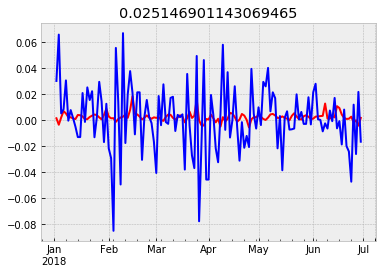

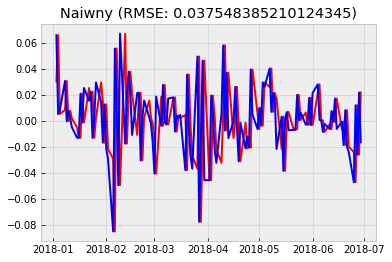

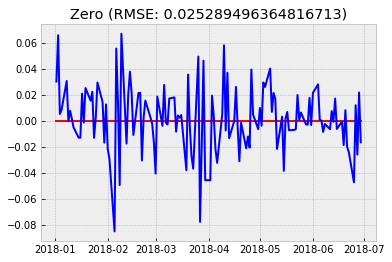

2018-01-02    0.001561
2018-01-03   -0.003414
2018-01-04    0.002156
2018-01-05    0.007056
2018-01-08    0.005266
2018-01-09    0.002423
2018-01-10    0.002310
2018-01-11    0.001454
2018-01-12    0.000944
2018-01-15    0.004095
2018-01-16    0.003884
2018-01-17    0.002993
2018-01-18    0.000810
2018-01-19    0.000907
2018-01-22    0.002550
2018-01-23    0.003567
2018-01-24    0.004450
2018-01-25    0.003975
2018-01-26    0.002255
2018-01-29    0.000742
2018-01-30    0.004091
2018-01-31    0.008801
2018-02-01    0.002865
2018-02-02    0.001540
2018-02-05    0.001615
2018-02-06   -0.001202
2018-02-07    0.000980
2018-02-08    0.002127
2018-02-09    0.002760
2018-02-12    0.004370
2018-02-13    0.001912
2018-02-14    0.008006
2018-02-15    0.018537
2018-02-16    0.004949
2018-02-19    0.004523
2018-02-20    0.002811
2018-02-21    0.000674
2018-02-22    0.001970
2018-02-23    0.003750
2018-02-26    0.002086
2018-02-27    0.001176
2018-02-28    0.002271
2018-03-01    0.001849
2018-03-02 

In [10]:
forecasts.plot(color='red', label='Forecast')
y_test_base.plot(color='blue', label='Real')
plt.title(rmse(y_test_base, forecasts))
plt.show()
show_est_plot(y_test_base, naiwny=True, label='Naiwny')
show_est_plot(y_test_base, zero=True, label='Zero')
print(forecasts.tolist())

## Test

In [11]:
order = (3,0,2)
variables = ['MIN_diff_1', 'MININDEX_diff_1_shift_19']
test["week"] = test.index.week
y_train_base = pd.concat([train1, val1, val2, val3]).asfreq('B', method='bfill')['y_return_ratio']
x_train_base = pd.concat([train1, val1, val2, val3]).asfreq('B', method='bfill')[variables]
y_test_base = test['y_return_ratio']
x_test_base = test[variables]

In [12]:
model = SARIMAX(y_train_base, x_train_base, order=order, freq='B', trend='c')
results = model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:         y_return_ratio   No. Observations:                 1565
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3748.650
Date:                Sun, 14 Apr 2019   AIC                          -7479.299
Time:                        23:24:52   BIC                          -7431.098
Sample:                    07-02-2012   HQIC                         -7461.381
                         - 06-29-2018                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0024      0.001      3.074      0.002       0.001       0.004
MIN_diff_1                   0.0010      0.000      2.886      0.004       0.000       0.

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [13]:
forecasts = []
for i in range(len(y_test_base)):
    y_train = pd.concat([y_train_base, y_test_base[:i]]).asfreq('B', method='bfill')
    x_train = pd.concat([x_train_base, x_test_base[:i]]).asfreq('B', method='bfill')
    model = SARIMAX(y_train, x_train, order=order, freq='B', trend='c', enforce_invertibility=False, enforce_stationarity=False)
    results = model.fit()
    forecasts.append(results.forecast(exog=x_test_base[i:i+1])[0])
forecasts = pd.Series(forecasts, index=y_test_base.index)

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


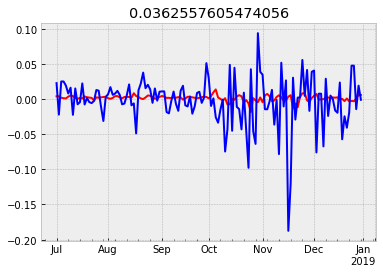

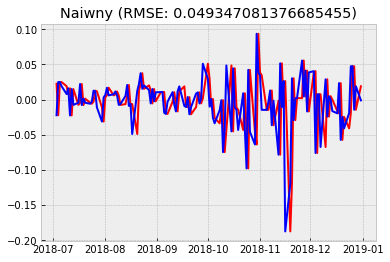

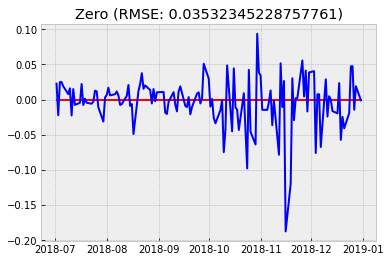

2018-07-02    0.003797
2018-07-03    0.003799
2018-07-04    0.001694
2018-07-05    0.001065
2018-07-06    0.000771
2018-07-09    0.003245
2018-07-10    0.005080
2018-07-11    0.004025
2018-07-12    0.001434
2018-07-13    0.000232
2018-07-16    0.001445
2018-07-17    0.000664
2018-07-18    0.003485
2018-07-19    0.002431
2018-07-20    0.001995
2018-07-23    0.001522
2018-07-24   -0.002384
2018-07-25    0.002251
2018-07-26    0.001849
2018-07-27    0.002359
2018-07-30    0.002763
2018-07-31    0.003179
2018-08-01    0.001083
2018-08-02    0.000184
2018-08-03    0.001500
2018-08-06    0.004031
2018-08-07    0.004114
2018-08-08    0.002289
2018-08-09    0.000957
2018-08-10    0.002805
2018-08-13    0.002833
2018-08-14    0.002847
2018-08-15    0.001767
2018-08-16    0.008148
2018-08-17    0.004133
2018-08-20    0.002747
2018-08-21    0.000736
2018-08-22   -0.000166
2018-08-23    0.002116
2018-08-24    0.004941
2018-08-27    0.004654
2018-08-28    0.002196
2018-08-29    0.000401
2018-08-30 

In [14]:
forecasts.plot(color='red', label='Forecast')
y_test_base.plot(color='blue', label='Real')
plt.title(rmse(y_test_base, forecasts))
plt.show()
show_est_plot(y_test_base, naiwny=True, label='Naiwny')
show_est_plot(y_test_base, zero=True, label='Zero')
print(forecasts)

In [8]:
text = """2018-07-02    0.003828
2018-07-03    0.003830
2018-07-04    0.001688
2018-07-05    0.000585
2018-07-06    0.000767
2018-07-09    0.003751
2018-07-10    0.004884
2018-07-11    0.002685
2018-07-12    0.001948
2018-07-13    0.000461
2018-07-16    0.001102
2018-07-17    0.000900
2018-07-18    0.003504
2018-07-19    0.002361
2018-07-20    0.001886
2018-07-23    0.001515
2018-07-24   -0.002465
2018-07-25    0.002252
2018-07-26    0.001752
2018-07-27    0.002278
2018-07-30    0.002979
2018-07-31    0.003020
2018-08-01    0.001134
2018-08-02    0.000193
2018-08-03    0.001686
2018-08-06    0.003912
2018-08-07    0.004415
2018-08-08    0.002516
2018-08-09    0.000930
2018-08-10    0.002548
2018-08-13    0.002704
2018-08-14    0.002865
2018-08-15    0.002078
2018-08-16    0.007959
2018-08-17    0.004138
2018-08-20    0.001857
2018-08-21    0.000741
2018-08-22   -0.000159
2018-08-23    0.002689
2018-08-24    0.004960
2018-08-27    0.005223
2018-08-28    0.004438
2018-08-29    0.000431
2018-08-30    0.000995
2018-08-31    0.003029
2018-09-03    0.003961
2018-09-04    0.002983
2018-09-05    0.001544
2018-09-06    0.001183
2018-09-07    0.001594
2018-09-10    0.002181
2018-09-11    0.001679
2018-09-12    0.002863
2018-09-13    0.002251
2018-09-14   -0.001295
2018-09-17    0.001408
2018-09-18    0.002600
2018-09-19    0.003343
2018-09-20    0.002294
2018-09-21    0.001085
2018-09-24    0.001023
2018-09-25    0.001489
2018-09-26    0.002389
2018-09-27    0.003120
2018-09-28    0.002885
2018-10-01    0.002146
2018-10-02    0.004461
2018-10-03    0.009263
2018-10-04    0.012709
2018-10-05    0.002720
2018-10-08   -0.000160
2018-10-09   -0.002600
2018-10-10    0.001640
2018-10-11   -0.008013
2018-10-12   -0.007488
2018-10-15   -0.001348
2018-10-16   -0.001110
2018-10-17    0.004457
2018-10-18    0.005444
2018-10-19    0.003877
2018-10-22   -0.004770
2018-10-23   -0.001510
2018-10-24   -0.003382
2018-10-25   -0.018644
2018-10-26    0.001475
2018-10-29   -0.002665
2018-10-30   -0.004625
2018-10-31    0.002171
2018-11-01   -0.004670
2018-11-02    0.005205
2018-11-05    0.007182
2018-11-06    0.004413
2018-11-07   -0.003200
2018-11-08   -0.001528
2018-11-09    0.003757
2018-11-12    0.005414
2018-11-13    0.002473
2018-11-14   -0.002557
2018-11-15   -0.002062
2018-11-16    0.003344
2018-11-19    0.001755
2018-11-20   -0.013373
2018-11-21   -0.005857
2018-11-22   -0.010035
2018-11-23    0.003026
2018-11-26    0.009715
2018-11-27    0.008126
2018-11-28   -0.002032
2018-11-29    0.005088
2018-11-30   -0.000681
2018-12-03    0.004327
2018-12-04    0.005580
2018-12-05   -0.000955
2018-12-06   -0.000559
2018-12-07   -0.000238
2018-12-10    0.001197
2018-12-11    0.002074
2018-12-12    0.000582
2018-12-13    0.001651
2018-12-14    0.001835
2018-12-17    0.002194
2018-12-18   -0.000561
2018-12-19    0.000358
2018-12-20   -0.002176
2018-12-21    0.000702
2018-12-24   -0.003240
2018-12-25   -0.002833
2018-12-26   -0.003081
2018-12-27    0.000671
2018-12-28    0.005883
2018-12-31    0.005953"""
lista = text.split('\n')

In [9]:
lista = [x.split('   ')[1] for x in lista]

In [10]:
lista = [float(x) if x[0] == '-' else float(x[1:]) for x in lista]

In [11]:
lista

[0.003828,
 0.00383,
 0.001688,
 0.000585,
 0.000767,
 0.003751,
 0.004884,
 0.002685,
 0.001948,
 0.000461,
 0.001102,
 0.0009,
 0.003504,
 0.002361,
 0.001886,
 0.001515,
 -0.002465,
 0.002252,
 0.001752,
 0.002278,
 0.002979,
 0.00302,
 0.001134,
 0.000193,
 0.001686,
 0.003912,
 0.004415,
 0.002516,
 0.00093,
 0.002548,
 0.002704,
 0.002865,
 0.002078,
 0.007959,
 0.004138,
 0.001857,
 0.000741,
 -0.000159,
 0.002689,
 0.00496,
 0.005223,
 0.004438,
 0.000431,
 0.000995,
 0.003029,
 0.003961,
 0.002983,
 0.001544,
 0.001183,
 0.001594,
 0.002181,
 0.001679,
 0.002863,
 0.002251,
 -0.001295,
 0.001408,
 0.0026,
 0.003343,
 0.002294,
 0.001085,
 0.001023,
 0.001489,
 0.002389,
 0.00312,
 0.002885,
 0.002146,
 0.004461,
 0.009263,
 0.012709,
 0.00272,
 -0.00016,
 -0.0026,
 0.00164,
 -0.008013,
 -0.007488,
 -0.001348,
 -0.00111,
 0.004457,
 0.005444,
 0.003877,
 -0.00477,
 -0.00151,
 -0.003382,
 -0.018644,
 0.001475,
 -0.002665,
 -0.004625,
 0.002171,
 -0.00467,
 0.005205,
 0.007182,
 